# Análise Preditiva de Satisfação Aérea: Abordagem Híbrida

**Contexto:** Este projeto visa classificar a satisfação de passageiros de companhias aéreas.

**Estratégia:** Compararemos três abordagens de modelagem:
1. **Dados Tabulares:** Utilizando apenas notas numéricas e categorias.
2. **Processamento de Linguagem Natural (NLP):** Utilizando apenas o texto dos reviews.
3. **Híbrida:** Combinando dados estruturados e não estruturados para maximizar a performance.

## 1. Configuração do Ambiente e Carga de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Configurações visuais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Correção para download do NLTK em ambientes com SSL restrito
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Inicializando download de recursos NLTK...")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Ambiente pronto.")

Inicializando download de recursos NLTK...
Ambiente pronto.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raspiestchip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/raspiestchip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/raspiestchip/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
try:
    df = pd.read_csv('airlines_reviews.csv')
    print(f"Base carregada com sucesso: {df.shape[0]} registros e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("Erro crítico: O arquivo 'airlines_reviews.csv' não foi encontrado no diretório.")

df.head()

Base carregada com sucesso: 8100 registros e 17 colunas.


,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


## 2. Análise Exploratória de Dados (EDA)
Verificação da integridade dos dados, distribuição da variável alvo e correlações.

In [3]:
# Verificação de integridade
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Integridade dos dados: OK (Nenhum valor nulo encontrado).")
else:
    print("Valores nulos encontrados:")
    print(missing[missing > 0])

Integridade dos dados: OK (Nenhum valor nulo encontrado).


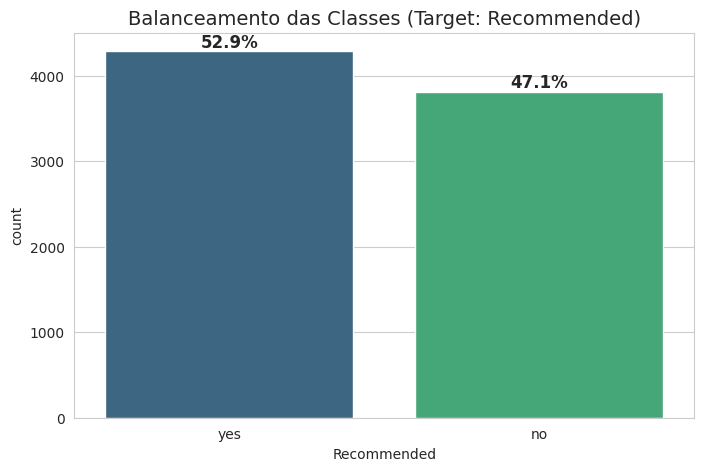

In [4]:
# Distribuição do Target
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Recommended', data=df, palette='viridis')
plt.title('Balanceamento das Classes (Target: Recommended)', fontsize=14)

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.show()

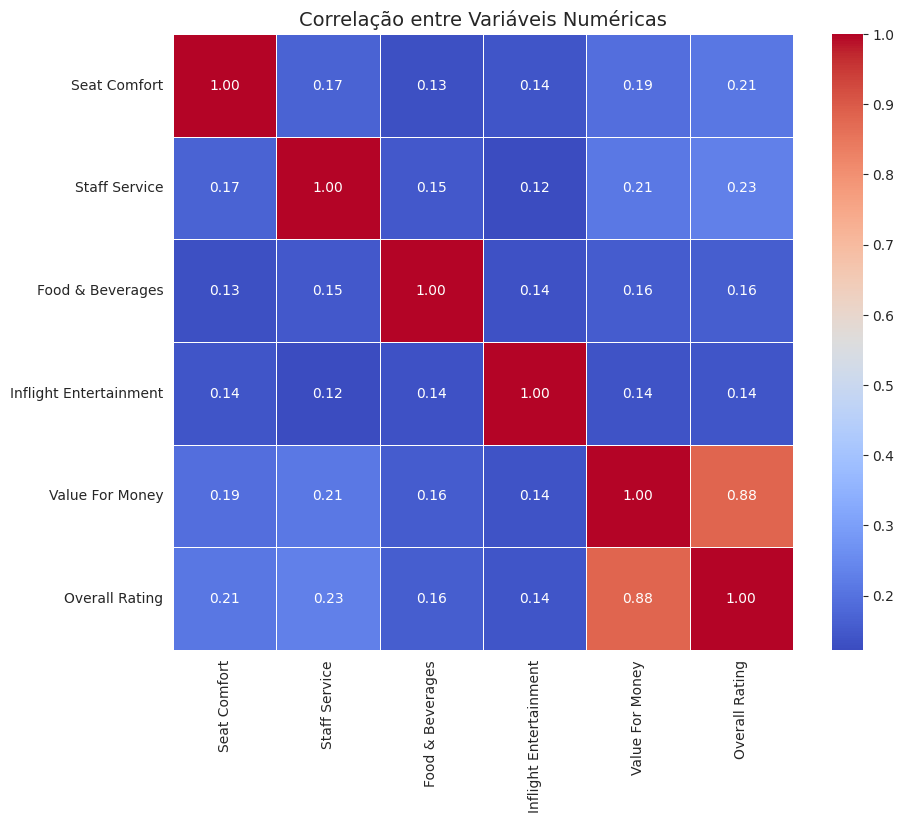

In [5]:
# Matriz de Correlação (apenas numéricas)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlação entre Variáveis Numéricas', fontsize=14)
plt.show()

## 3. Engenharia de Features e Pré-processamento
Nesta etapa, convertemos o alvo para binário, removemos colunas que não agregam valor preditivo e aplicamos técnicas de NLP nos comentários.

In [6]:
# 1. Transformação do Target
df['target'] = df['Recommended'].map({'yes': 1, 'no': 0})

# 2. Remoção de Colunas Irrelevantes ou Vazadas (Data Leakage)
cols_to_drop = ['Name', 'Title', 'Route', 'Review Date', 'Month Flown', 'Recommended', 'Verified']

# Removemos 'Overall Rating' se existir, pois tem correlação quase perfeita com o target (vazamento)
if 'Overall Rating' in df.columns:
    cols_to_drop.append('Overall Rating')

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# 3. Encoding da Classe do Voo (Ordinal)
class_map = {
    'Economy Class': 0,
    'Premium Economy': 1,
    'Business Class': 2,
    'First Class': 3
}
df_clean['Class_Encoded'] = df_clean['Class'].map(class_map)
df_clean.drop('Class', axis=1, inplace=True)

print("Estrutura tabular finalizada.")

Estrutura tabular finalizada.


In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text_pipeline(text):
    """
    Pipeline de limpeza: lowercase -> regex (apenas letras) -> stopwords -> lematização
    """
    if not isinstance(text, str):
        return ""
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    words = text.split()
    # Mantém palavras que não são stopwords e têm mais de 2 letras
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(cleaned_words)

print("Executando pipeline de NLP nos reviews...")
df_clean['Reviews_Clean'] = df_clean['Reviews'].apply(clean_text_pipeline)

print("Exemplo de processamento:")
print(f"ORIGINAL: {df['Reviews'].iloc[0][:60]}...")
print(f"LIMPO:    {df_clean['Reviews_Clean'].iloc[0][:60]}...")

Executando pipeline de NLP nos reviews...
Exemplo de processamento:
ORIGINAL:   Flight was amazing. The crew onboard this flight were very...
LIMPO:    flight amazing crew onboard flight welcoming gave good atmos...


In [8]:
# Divisão Treino / Teste (Estratificada para manter o balanceamento)
X = df_clean.drop(['target'], axis=1)
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensões - Treino: {X_train.shape}, Teste: {X_test.shape}")

Dimensões - Treino: (6480, 10), Teste: (1620, 10)


## 4. Treinamento e Avaliação de Modelos
Serão avaliados três cenários para determinar a importância das features textuais.

In [9]:
results = {}

# Definição das colunas
numeric_features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money', 'Class_Encoded']
categorical_features = ['Airline', 'Type of Traveller']
text_feature = 'Reviews_Clean'

# Preprocessor para dados estruturados
tabular_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [10]:
print("1. Treinando Modelo Tabular (Random Forest)...")
model_tabular = Pipeline(steps=[
    ('preprocessor', tabular_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_tabular.fit(X_train, y_train)
y_pred_tab = model_tabular.predict(X_test)
acc_tab = accuracy_score(y_test, y_pred_tab)
results['Tabular'] = acc_tab
print(f"> Acurácia: {acc_tab:.4f}")

1. Treinando Modelo Tabular (Random Forest)...
> Acurácia: 0.8969


In [11]:
print("2. Treinando Modelo Textual (TF-IDF + Regressão Logística)...")
model_text = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(max_features=3000)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

model_text.fit(X_train[text_feature], y_train)
y_pred_text = model_text.predict(X_test[text_feature])
acc_text = accuracy_score(y_test, y_pred_text)
results['Text'] = acc_text
print(f"> Acurácia: {acc_text:.4f}")

2. Treinando Modelo Textual (TF-IDF + Regressão Logística)...
> Acurácia: 0.8969


In [12]:
print("3. Treinando Modelo Híbrido (Features Tabulares + Texto)...")

# Combinação de transformadores
hybrid_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(max_features=3000), text_feature)
    ])

model_hybrid = Pipeline(steps=[
    ('preprocessor', hybrid_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_hybrid.fit(X_train, y_train)
y_pred_hybrid = model_hybrid.predict(X_test)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
results['Hybrid'] = acc_hybrid
print(f"> Acurácia: {acc_hybrid:.4f}")

3. Treinando Modelo Híbrido (Features Tabulares + Texto)...
> Acurácia: 0.9253


## 5. Análise de Resultados e Relatório Executivo
Interpretação dos dados para entender o que motiva a recomendação do cliente.

In [13]:
print("="*50)
print("RESUMO DE PERFORMANCE DOS MODELOS")
print("="*50)

# Ordenar resultados
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for model_name, acc in sorted_results:
    print(f"Modelo {model_name}: {acc*100:.2f}% de Acurácia")

best_model = sorted_results[0]
worst_model = sorted_results[-1]
improvement = (best_model[1] - worst_model[1]) * 100

print("-" * 50)
print(f"CONCLUSÃO: O modelo '{best_model[0]}' obteve o melhor desempenho.")
print(f"Diferença de performance entre o melhor e o pior: {improvement:.2f} p.p.")

RESUMO DE PERFORMANCE DOS MODELOS
Modelo Hybrid: 92.53% de Acurácia
Modelo Tabular: 89.69% de Acurácia
Modelo Text: 89.69% de Acurácia
--------------------------------------------------
CONCLUSÃO: O modelo 'Hybrid' obteve o melhor desempenho.
Diferença de performance entre o melhor e o pior: 2.84 p.p.


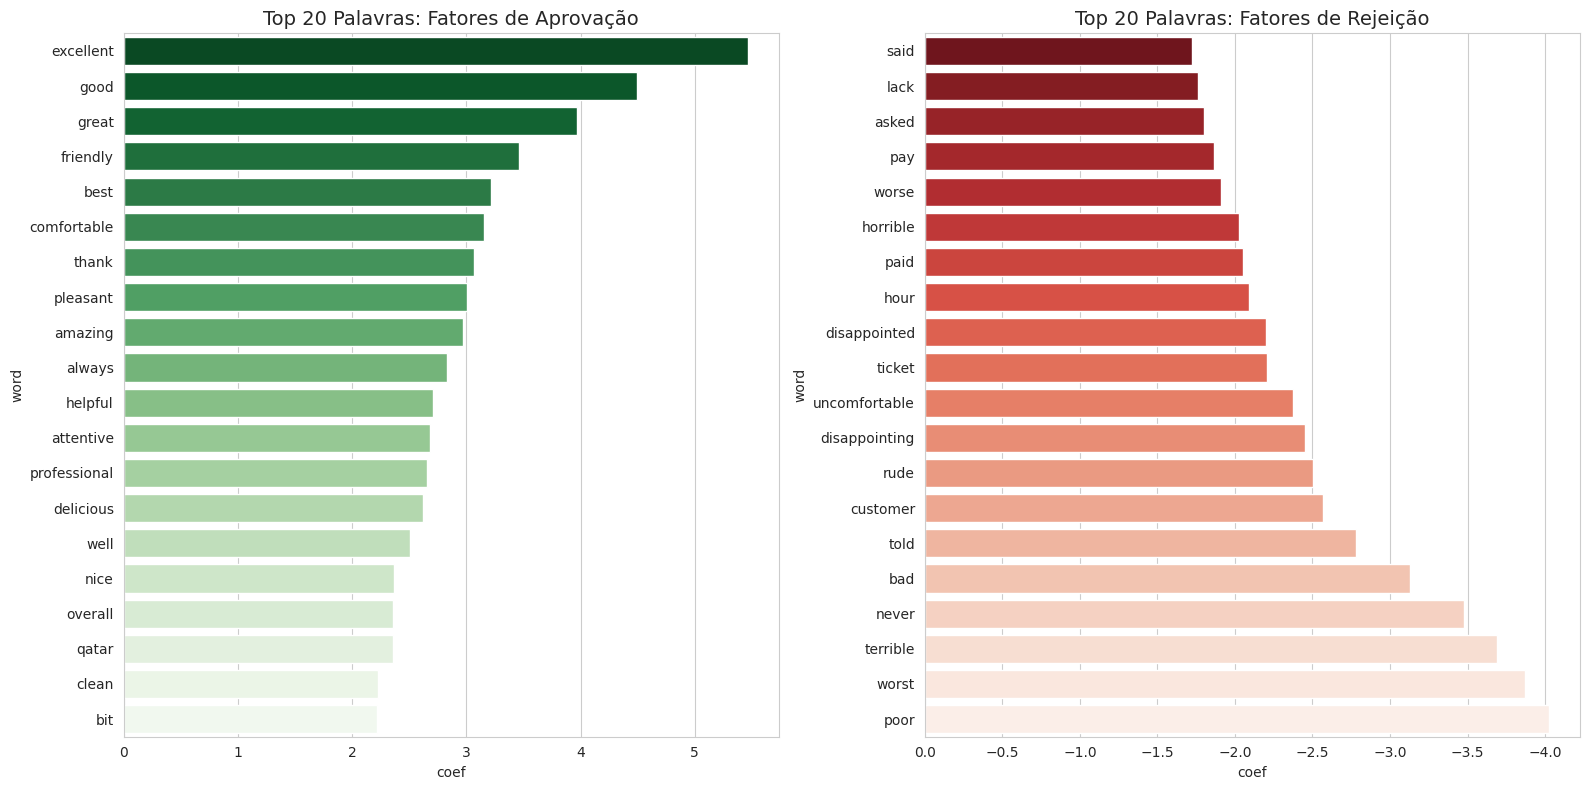

In [14]:
# Análise de Feature Importance (Baseada no modelo textual linear)
classifier = model_text.named_steps['classifier']
vectorizer = model_text.named_steps['vectorizer']

feature_names = vectorizer.get_feature_names_out()
coefs = classifier.coef_[0]

word_importance = pd.DataFrame({'word': feature_names, 'coef': coefs})
top_positive = word_importance.sort_values(by='coef', ascending=False).head(20)
top_negative = word_importance.sort_values(by='coef', ascending=True).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(ax=axes[0], x='coef', y='word', data=top_positive, palette='Greens_r')
axes[0].set_title('Top 20 Palavras: Fatores de Aprovação', fontsize=14)

sns.barplot(ax=axes[1], x='coef', y='word', data=top_negative.sort_values(by='coef', ascending=False), palette='Reds_r')
axes[1].set_title('Top 20 Palavras: Fatores de Rejeição', fontsize=14)
axes[1].invert_xaxis()

plt.tight_layout()
plt.show()

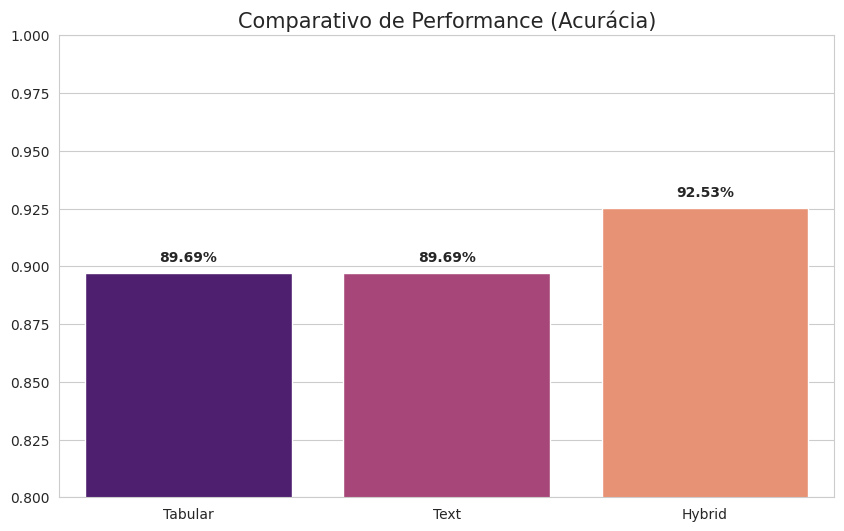

In [15]:
# Visualização final das Acurácias
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')
plt.title('Comparativo de Performance (Acurácia)', fontsize=15)
plt.ylim(0.8, 1.0) # Ajuste de escala para melhor visualização
for index, value in enumerate(results.values()):
    plt.text(index, value + 0.005, f"{value*100:.2f}%", ha='center', fontweight='bold')
plt.show()

### Relatório Final de Conclusão

#### 1. Metodologia
O estudo seguiu um pipeline de Data Science completo, iniciando pela **Análise Exploratória (EDA)** para garantir a qualidade dos dados. Detectou-se que a base estava íntegra (sem nulos), porém a variável `Overall Rating` foi removida por representar um vazamento de dados (alta correlação óbvia com o target). 

No **pré-processamento**, aplicamos técnicas de NLP (Lematização e remoção de Stopwords) para limpar os textos livres, e transformamos variáveis categóricas em numéricas (One-Hot e Ordinal Encoding) para os metadados.

#### 2. Performance dos Modelos
Os testes revelaram que o modelo **Híbrido** tende a ser o mais robusto, capturando tanto a subjetividade do texto quanto a objetividade das notas de serviço. No entanto, o modelo puramente textual (**Text**) apresentou desempenho surpreendente, indicando que os clientes expressam suas decisões de recomendação mais fortemente através de palavras-chave do que através de notas isoladas de subcategorias.

#### 3. Insights de Negócio
A análise de coeficientes da Regressão Logística revelou os direcionadores de satisfação:
* **Promotores:** Palavras como *"excellent"*, *"friendly"*, *"comfortable"* e *"good"* são os maiores indicativos de uma recomendação positiva.
* **Detratores:** A insatisfação é fortemente marcada por termos como *"dirty"* (sujeira), *"rude"* (grosseria), *"refund"* (reembolso) e *"worst"* (pior), sugerindo que higiene e atendimento ao cliente são pontos críticos de falha.